**Loan Defaultment Prediction**

In [47]:
#Lets start by loading the necessary libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats as ss
import statistics

print(plt.style.available)
plt.style.use('dark_background')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


**DataSet Loading . . .**

In [48]:
#Importing the data and checking its general description
df = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\Jack\Loan_Defaultment\Loan_default.csv")
print(df.info())
print(df.tail(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

Since we have no nulls in our dataset, we can start by checking for **duplicates**

In [49]:
#Lets check for duplicates in the dataset we just loaded
print(df[df.duplicated()])

#Since we have no duplicates in our data, we can rename some of the columns foreasy readability
df.rename(columns={'Income':'Annual Income','NumCreditLines':'Number of Credit Lines','DTIRatio':'Debt to Income Ratio'},inplace=True)

Empty DataFrame
Columns: [LoanID, Age, Income, LoanAmount, CreditScore, MonthsEmployed, NumCreditLines, InterestRate, LoanTerm, DTIRatio, Education, EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner, Default]
Index: []


In [50]:
#Lets start checking for outliers in our dataframe, we are going to use a function to try and detect outliers and remove them
x = len(df)
def outliers(x):
    Arithmetic_Mean = statistics.mean(df[x])
    Standard_Deviation = statistics.mean(df[x])

    lower_limit = Arithmetic_Mean - (3*Standard_Deviation)
    Upper_limit = Arithmetic_Mean + (3*Standard_Deviation)

    outlier = df[(df[x]<lower_limit) | (df[x]>Upper_limit)]
    if len(outlier) > 0:
        print(x,'has',len(outlier),'outliers')
        df.drop(df[df[x] < lower_limit].index, inplace=True)
        df.drop(df[df[x] > Upper_limit].index, inplace=True)

        Arithmetic_mean = statistics.mean(x)
        Standard_Deviation = statistics.stdev(x)
        lower_limit = Arithmetic_Mean - (3*Standard_Deviation)
        Upper_limit = Arithmetic_Mean + (3*Standard_Deviation)
        outlier = df[(df[x]<lower_limit) | (df[x]>Upper_limit)]
        print(len(outlier))
    else:
        print("No outlier Detected in", x)

    del Arithmetic_Mean
    del Standard_Deviation
    del lower_limit
    del Upper_limit
    del outlier

    return 'Done'

outliers('Annual Income')
outliers('LoanAmount')
outliers('InterestRate')
outliers('LoanTerm')
outliers('Debt to Income Ratio')

#Since the credit score cannot be greater than 850 or less than 0, we are going to use if loop
if len(df[(df['CreditScore']>850) | (df['CreditScore']<300)])>0 :
    df.drop(df[(df['CreditScore']>850)].index, inplace=True)
    df.drop(df[(df['CreditScore']<300)].index, inplace=True)
else:
    print("No credit score above 850 or below 0 detected")

y = len(df)

print(x - y)

No outlier Detected in Annual Income
No outlier Detected in LoanAmount
No outlier Detected in InterestRate
No outlier Detected in LoanTerm
No outlier Detected in Debt to Income Ratio
No credit score above 850 or below 0 detected
0


In [51]:
#Lets convert the datatypes of some columns to minimise the space being used by the program
df['Age'] = df['Age'].astype(np.int8)
df['Annual Income'] = df['Annual Income'].astype(np.float64)
df['LoanAmount'] = df['LoanAmount'].astype(np.float64)
df['Default'] = df['Default'].astype('category')
df['LoanID'] = df['LoanID'].astype('category')

In [52]:
#Lets create the loan to income ratio, this will be used to see if the ratio matters 
#Since we have diverse income and diverse loan amount
df['Loan to Income Ratio'] = df['LoanAmount'] / df['Annual Income']

#Lets create a new column that can be understood easily for defaultment
def changer(x):
    if x == '1':
        return 'Yes'
    elif x == '0':
        return 'No'
    else:
        return x

df['Loan Defaulted?'] = df['Default'].astype(str).apply(changer)

del changer

df['Loan Term in Years'] = df['LoanTerm'] /12

**Data Summary**<br>
This is essential in getting a brief oveerview of what we are dealing with before we start our analysis

In [53]:
#Lets get a summary of our data
df.describe()

,Age,Annual Income,LoanAmount,CreditScore,MonthsEmployed,Number of Credit Lines,InterestRate,LoanTerm,Debt to Income Ratio,Loan to Income Ratio,Loan Term in Years
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,2.177480,3.002158
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,2.178357,1.414111
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.033749,1.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.803628,2.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,1.546720,3.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,2.671744,4.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,16.532460,5.000000


The **Debt to Income Ratio** is the ratio of income amount someone uses to pay for they debt they have be it bank loans, car loan, mortgage etc while **Loan to Income Ratio** is the comparison between annual income and the loan amount they  have in this dataset

**T_Test** is a statistical test used to test the hypothesis about the mean. In t_test:<br>
**H<sub>0</sub>** states that the mean of the 2 groups doesn't have a statistically significant difference. We reject H<sub>0</sub> if p_value is less than 0.05 <br>
**H<sub>1</sub>** states that the mean between the 2 groups are statistically significant. If we reject H<sub>0</sub> we automatically conclude H<sub>1</sub> to be true

**Exploratory Data Analysis**<br>
**Q1.	Does someone's age have a relationship with the loan default status?**

The average age in our dataset is 43.498306226429136
Loan Defaulted?
No     44.409962
Yes    36.559539
Name: Age, dtype: float64
The pvalue is 0.0000000000 and the tstatistic is -86.0028059077


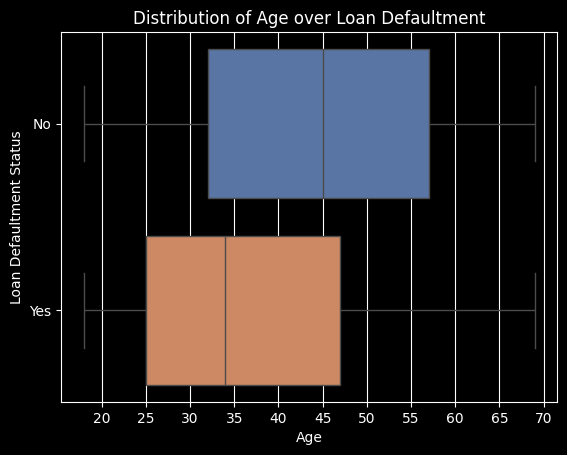

In [54]:
#What is the average age in our dataset?
print("The average age in our dataset is",statistics.mean(df['Age']))
print(df.groupby('Loan Defaulted?')['Age'].mean())

#The average mean of ages between the people who default loan has a big difference, we are going to use a ttest to see if its statistically significant
Yes_default = df[df['Loan Defaulted?']=='Yes'][['Age','LoanID']]
No_default = df[df['Loan Defaulted?']=='No'][['Age','LoanID']]

No_default['Age'] = No_default['Age'].astype(np.float32)
Yes_default['Age'] = Yes_default['Age'].astype(np.float32)

result = ss.ttest_ind(Yes_default['Age'],No_default['Age'])
Tstatistic = f"{result.statistic:.10f}"
Pvalue = f"{result.pvalue:.10f}"
print("The pvalue is",Pvalue,"and the tstatistic is",Tstatistic)

del result
del Tstatistic
del Pvalue
del No_default
del Yes_default

#Lets try to visualise the relationship between loan defaultment and the age
a = pd.DataFrame(df.groupby(['Age','Loan Defaulted?'])['LoanID'].count())
a.reset_index(inplace= True)

plt.grid()
sns.boxplot(x='Age',y='Loan Defaulted?',data=df,palette='deep',hue='Loan Defaulted?',legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.xlabel("Age")
plt.ylabel("Loan Defaultment Status")
plt.title("Distribution of Age over Loan Defaultment")
plt.plot()

del a
del ax

According to the above graph and ttest outcome, we can conclude that the age of someone tends to have relationship and can be used to predict the likelyhood of someone paying back their loans<br>
Young people have a higher risk of defaulting than the elders

**Q2.	Is there a relationship between income, loan amount, and default status?🤔🤔**

-0.000865325655925826
                               Annual Income  LoanAmount
Loan Defaulted?                                         
No              Annual Income       1.000000    0.025807
                LoanAmount          0.025807    1.000000
Yes             Annual Income       1.000000   -0.123785
                LoanAmount         -0.123785    1.000000
The pvalue is 0.0000000000 and the tstatistic is 43.9556928291


[]

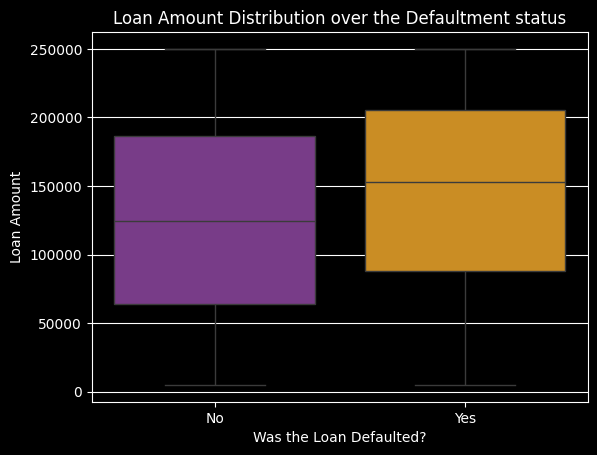

In [55]:
#Is there a relationship between income level and loan amount
print(df['Annual Income'].corr(df['LoanAmount']))
print(df.groupby('Loan Defaulted?')[['Annual Income','LoanAmount']].corr())
#Someones income has a very little relationship with the loan amount requested.

#Does loan amount have a relationship with the defaultment?
Yes_default = df[df['Loan Defaulted?']=='Yes'][['LoanAmount','LoanID']]
No_default = df[df['Loan Defaulted?']=='No'][['LoanAmount','LoanID']]

#We are going to use a ttest to analyze the relationship between loan amount and defaultment
result = ss.ttest_ind(Yes_default['LoanAmount'],No_default['LoanAmount'])
Tstatistic = f"{result.statistic:.10f}"
Pvalue = f"{result.pvalue:.10f}"
print("The pvalue is",Pvalue,"and the tstatistic is",Tstatistic)

del result
del Tstatistic
del Pvalue
del No_default
del Yes_default

plt.grid()
sns.boxplot(x='Loan Defaulted?', y='LoanAmount',data=df,palette='CMRmap',hue='Loan Defaulted?')
plt.xlabel('Was the Loan Defaulted?')
plt.ylabel('Loan Amount')
plt.title("Loan Amount Distribution over the Defaultment status")
plt.plot()

The pvalue is 0.0000000000 and the tstatistic is -50.3346048099


[]

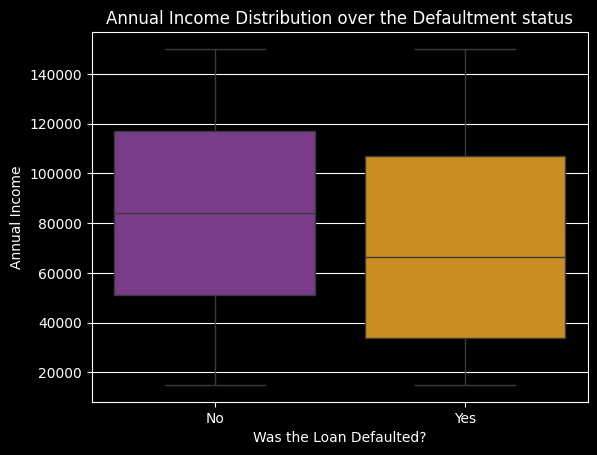

In [56]:
Yes_default = df[df['Loan Defaulted?']=='Yes'][['Annual Income','LoanID']]
No_default = df[df['Loan Defaulted?']=='No'][['Annual Income','LoanID']]

#We are going to use a ttest to analyze the relationship between loan amount and defaultment
result = ss.ttest_ind(Yes_default['Annual Income'],No_default['Annual Income'])
Tstatistic = f"{result.statistic:.10f}"
Pvalue = f"{result.pvalue:.10f}"
print("The pvalue is",Pvalue,"and the tstatistic is",Tstatistic)

del result
del Tstatistic
del Pvalue
del No_default
del Yes_default

plt.grid()
sns.boxplot(x='Loan Defaulted?', y='Annual Income',data=df,palette='CMRmap',hue='Loan Defaulted?')
plt.xlabel('Was the Loan Defaulted?')
plt.ylabel('Annual Income')
plt.title("Annual Income Distribution over the Defaultment status")
plt.plot()

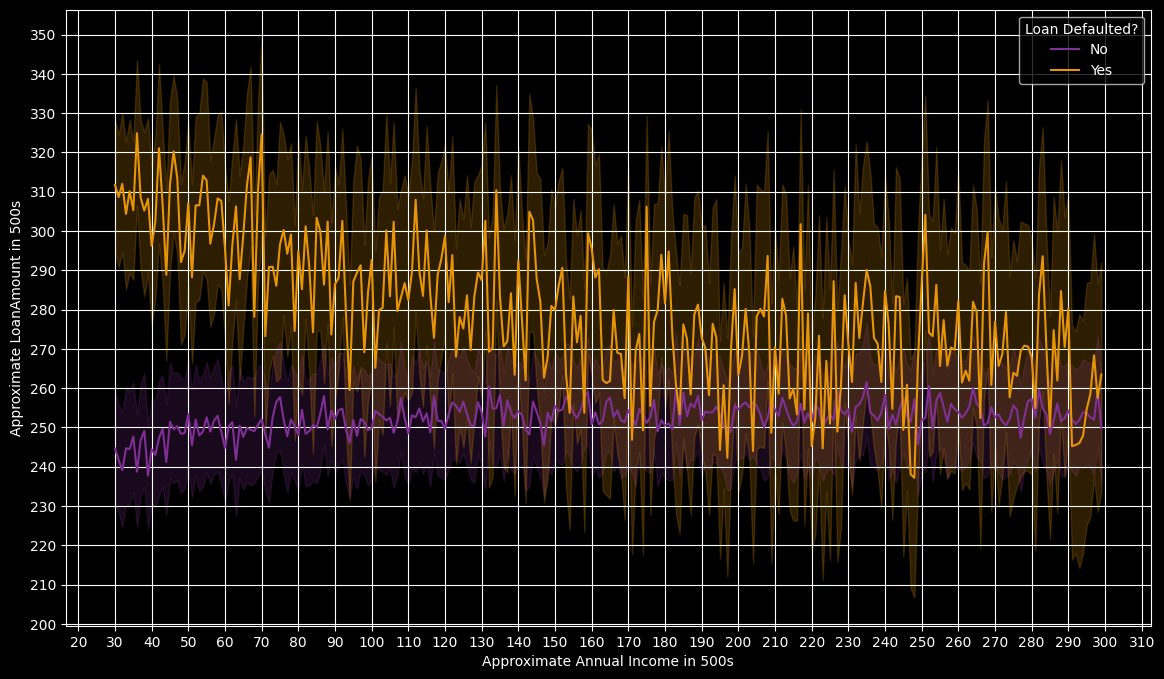

According to the graph above, their tends to be a relationship between the amount someone earns, loan amount and defaultment status


In [57]:
#Lets try to find the equilibrium between loan amount and income for people who default and pay their loans
#Lets start by minimizing the values of annual income and loan amount
df1 = df
df1['Approximate Annual Income in 500s'] = df1['Annual Income'] // 500
df1['Approximate LoanAmount in 500s'] = df1['LoanAmount'] // 500

df2 = pd.DataFrame(df1.groupby(['Approximate Annual Income in 500s','Approximate LoanAmount in 500s','Loan Defaulted?'])['LoanID'].count())
df2.reset_index(inplace= True)

#Lets plot a line graph of Loan Amount against Annual Income
plt.figure(figsize=(14,8))
plt.grid()
sns.lineplot(x='Approximate Annual Income in 500s',y='Approximate LoanAmount in 500s',data=df2, hue='Loan Defaulted?',palette='CMRmap')
ax= plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10))
plt.plot()
plt.show()

del df1
del df2
del ax
print("According to the graph above, their tends to be a relationship between the amount someone earns, loan amount and defaultment status")

Loan to Income Ratio has 6399 outliers
The p-value is 0.0000000000 and the t-statistic is 60.4123668715


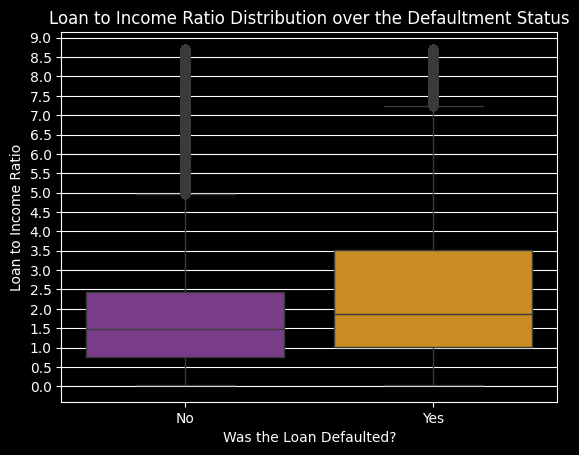

In [58]:
#Lets create a temporary dataframe so tha we don't interfere with the original dataframe
df1 = df.copy()

def outliers(x):
    Arithmetic_Mean = statistics.mean(df1[x])
    Standard_Deviation = statistics.stdev(df1[x])

    lower_limit = Arithmetic_Mean - (3 * Standard_Deviation)
    upper_limit = Arithmetic_Mean + (3 * Standard_Deviation)

    outlier = df1[(df1[x] < lower_limit) | (df1[x] > upper_limit)]
    if len(outlier) > 0:
        print(x, 'has', len(outlier), 'outliers')
        df1.drop(df1[df1[x] < lower_limit].index, inplace=True)
        df1.drop(df1[df1[x] > upper_limit].index, inplace=True)
    else:
        print("No outlier detected in", x)

    return 'Done'

# We need to first detect and remove pottential outliers in Loan to Income Ratio
outliers("Loan to Income Ratio")

# Separate the data based on loan default status
Yes_default = df1[df1['Loan Defaulted?'] == 'Yes'][["Loan to Income Ratio", 'LoanID']]
No_default = df1[df1['Loan Defaulted?'] == 'No'][["Loan to Income Ratio", 'LoanID']]

# Perform a t-test to analyze the relationship between loan amount and defaultment
result = ss.ttest_ind(Yes_default["Loan to Income Ratio"], No_default["Loan to Income Ratio"])
Tstatistic = f"{result.statistic:.10f}"
Pvalue = f"{result.pvalue:.10f}"
print("The p-value is", Pvalue, "and the t-statistic is", Tstatistic)

# Plot the boxplot
plt.grid()
sns.boxplot(x='Loan Defaulted?', y="Loan to Income Ratio", data=df1, palette='CMRmap', hue='Loan Defaulted?')
ax= plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
plt.xlabel('Was the Loan Defaulted?')
plt.ylabel('Loan to Income Ratio')
plt.title("Loan to Income Ratio Distribution over the Defaultment Status")
plt.show()

**Conclusion** The annual income and the loan amount someone recieves independently affects the loan defaultment status.<br>
People who tend to earn more than the average income tends to show tends to exhibit a trait of paying their loans more than the ones who earn less<br>
As for the Loan Amount, the higher the loan amount the higher the chance of not paying the loan

**Q3 Is there a relationship between Debt to Income Ratio, Loan to Income Ratio, and loan default status?**

                      Loan to Income Ratio  Debt to Income Ratio  LoanAmount  \
Loan to Income Ratio              1.000000              0.000619    0.554730   
Debt to Income Ratio              0.000619              1.000000    0.001122   
LoanAmount                        0.554730              0.001122    1.000000   
Annual Income                    -0.613392              0.000205   -0.000865   

                      Annual Income  
Loan to Income Ratio      -0.613392  
Debt to Income Ratio       0.000205  
LoanAmount                -0.000865  
Annual Income              1.000000  
                                      Loan to Income Ratio  \
Loan Defaulted?                                              
No              Loan to Income Ratio              1.000000   
                Debt to Income Ratio             -0.000552   
                LoanAmount                        0.560640   
                Annual Income                    -0.598853   
Yes             Loan to Income Ratio 

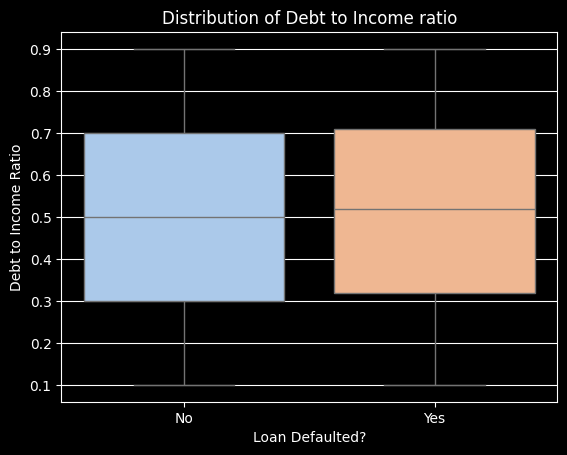

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
TtestResult(statistic=9.722061942188075, pvalue=2.4499161124758243e-22, df=255345.0)
The p value of the Debt to Income Ratio is very small indicating that the difference between the defaultment status is statistically significant
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
TtestResult(statistic=91.91718392930751, pvalue=0.0, df=255345.0)
The p value of the Loan to Income Ratio is very small indicating that the difference between the defaultment status is statistically significant


In [59]:
#Is there a relationship between Loan to Income Ratio, Debt to income ratio and loan amount?
print(df[['Loan to Income Ratio','Debt to Income Ratio','LoanAmount','Annual Income']].corr())
print(df.groupby('Loan Defaulted?')[['Loan to Income Ratio','Debt to Income Ratio','LoanAmount','Annual Income']].corr())

#Lets use a box plot to analyze the relationship between Loan defaultment and debt to income ratio
plt.grid()
sns.boxplot(x='Loan Defaulted?',y='Debt to Income Ratio',data=df,hue='Loan Defaulted?',palette='pastel')
plt.title('Distribution of Debt to Income ratio')
plt.plot()
plt.show()

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
a = df[df['Loan Defaulted?']=='Yes'][['Debt to Income Ratio','Loan to Income Ratio']]
b = df[df['Loan Defaulted?']=='No'][['Debt to Income Ratio','Loan to Income Ratio']]

print(ss.ttest_ind(a['Debt to Income Ratio'],b['Debt to Income Ratio']))
print("The p value of the Debt to Income Ratio is very small indicating that the difference between the defaultment status is statistically significant")

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
print(ss.ttest_ind(a['Loan to Income Ratio'],b['Loan to Income Ratio']))
print("The p value of the Loan to Income Ratio is very small indicating that the difference between the defaultment status is statistically significant")

del a
del b

**Conclusion** Both debt to income ratio and loan to income ratio shows a good relationship with credit defaultment<br>
Debt to Income ratio is the ratio of the income that goes to paying loans such as mortgage, student loans, bank\sacco loans<br>
Loan to Income ratio is the comparison between the money borrowed and the annual income of someone<br>

**4 Does employment type and months employed affect the default status?**

Loan Defaulted?                  No       Yes
EmploymentType                               
Full-time                  0.905366  0.094634
Part-time                  0.880348  0.119652
Self-employed              0.885380  0.114620
Unemployed                 0.864471  0.135529
Conditional Probabilities  0.883872  0.116128
EmploymentType             Full-time  Part-time  Self-employed  Unemployed
Loan Defaulted?                                                           
No                          0.255355   0.250268       0.249914    0.244464
Yes                         0.203150   0.258895       0.246248    0.291707
Conditional Probabilities   0.249292   0.251270       0.249488    0.249950


C:\Users\hp\AppData\Local\Temp\ipykernel_12588\3347168954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['Default'] = a['Default'].astype(np.int16)


                      df        sum_sq    mean_sq          F         PR(>F)
EmploymentType       3.0     54.374333  18.124778  176.94597  1.301524e-114
Residual        255343.0  26155.074700   0.102431        NaN            NaN


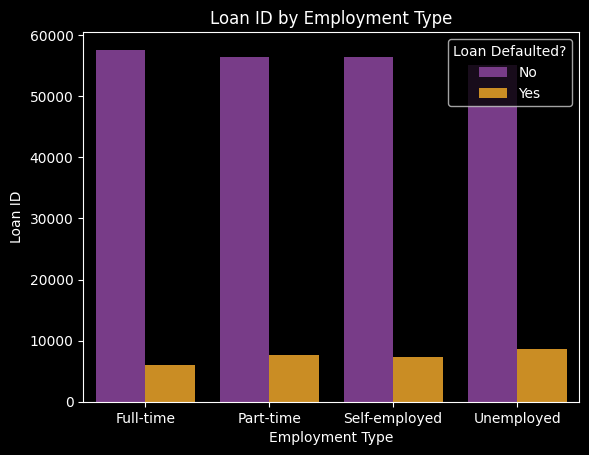

In [60]:
#To explore if there is a relationship between employment type and the defaultment status, I will use conditional probability
print(pd.crosstab(df['EmploymentType'],df['Loan Defaulted?'],normalize='index',margins=True,margins_name='Conditional Probabilities'))
print(pd.crosstab(df['Loan Defaulted?'],df['EmploymentType'],normalize='index',margins=True,margins_name='Conditional Probabilities'))

a = df[['Default','EmploymentType']]
a['Default'] = a['Default'].astype(np.int16)
model = ols('Default~EmploymentType',data=a).fit()
print(sm.stats.anova_lm(model,type=2))

a = pd.DataFrame(df.groupby(['EmploymentType','Loan Defaulted?'],observed=True)['LoanID'].count())
a.reset_index(inplace=True)

#Lets try to visualize our outputs using a barplot
sns.barplot(x='EmploymentType', y='LoanID', data=a, palette='CMRmap',hue='Loan Defaulted?',errorbar=None)
plt.xlabel('Employment Type')
plt.ylabel('Loan ID')
plt.title('Loan ID by Employment Type')
plt.show()

del a
del model

The general correlation between Months Employed and Loan Amount is 0.0028168362581519548
The relationship between employment in months and loan amount for different defaultment groups is
                                 MonthsEmployed  LoanAmount
Loan Defaulted?                                           
No              MonthsEmployed        1.000000    0.010413
                LoanAmount            0.010413    1.000000
Yes             MonthsEmployed        1.000000    0.018758
                LoanAmount            0.018758    1.000000

 TtestResult(statistic=-49.43956796147565, pvalue=0.0, df=255345.0)


C:\Users\hp\AppData\Local\Temp\ipykernel_12588\4116383325.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = pd.DataFrame(df.groupby(['MonthsEmployed','Default'])['LoanAmount'].apply(geometric_mean))


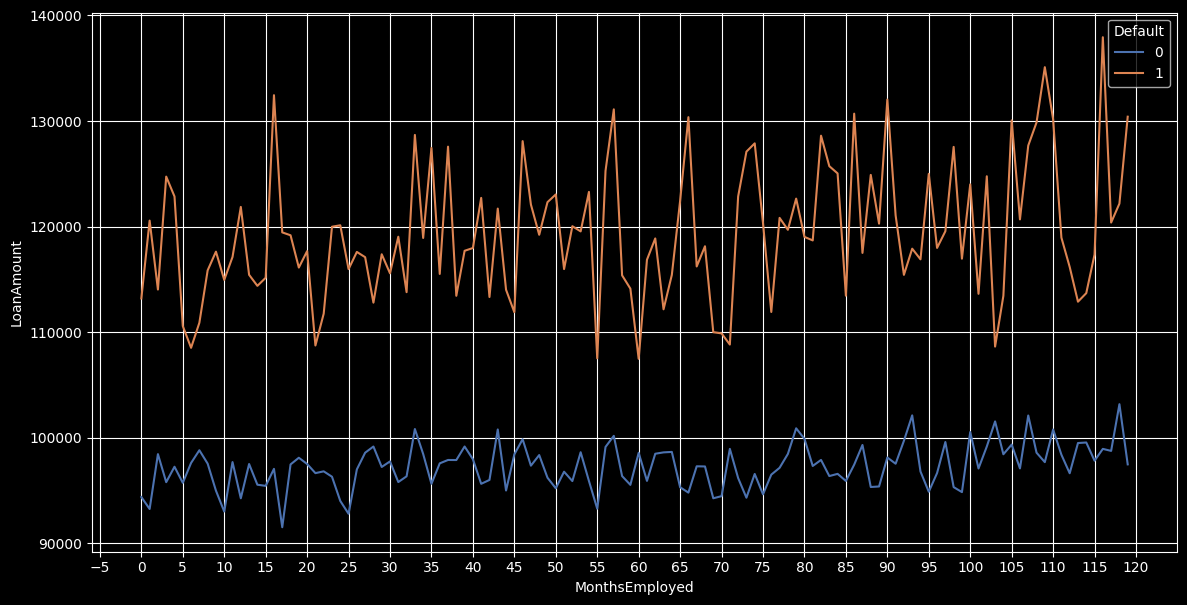

The average loan amount is 99592.70977982608
The average loan amount for defaultment and not default is Loan Defaulted?
No      97317.115875
Yes    118749.256051
Name: LoanAmount, dtype: float64


In [61]:
#Does the duration of being employed have a relationship with loan defaultment
print("The general correlation between Months Employed and Loan Amount is",df['MonthsEmployed'].corr(df['LoanAmount']))
print("The relationship between employment in months and loan amount for different defaultment groups is\n",df.groupby('Loan Defaulted?')[['MonthsEmployed','LoanAmount']].corr())

#Lets create 2 dataframes that can be used in t-test to analyse the relationship between the 2 groups of defaultment
a = df[df['Loan Defaulted?']=='Yes'][['LoanAmount','MonthsEmployed']]
b = df[df['Loan Defaulted?']=='No'][['LoanAmount','MonthsEmployed']]

print("\n",ss.ttest_ind(a['MonthsEmployed'],b['MonthsEmployed']))
del a
del b

#Lets create a function that can be used to find the statistical significant mean(geometric mean) of the loan amount borrowed
def geometric_mean(series):
    return ss.gmean(series)

#Lets find the average amount borrowed by each group of defaultment staus, months employed and loan amount
a = pd.DataFrame(df.groupby(['MonthsEmployed','Default'])['LoanAmount'].apply(geometric_mean))
a.reset_index(inplace=True)

plt.figure(figsize=(14,7))
plt.grid()
sns.lineplot(x='MonthsEmployed',y='LoanAmount',data=a, palette='deep',hue='Default')
ax= plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.plot()
plt.show()

print("The average loan amount is",ss.gmean(df['LoanAmount']))

print("The average loan amount for defaultment and not default is",df.groupby('Loan Defaulted?')['LoanAmount'].apply(geometric_mean))

del a
del ax

TtestResult(statistic=-49.43956796147565, pvalue=0.0, df=255345.0)


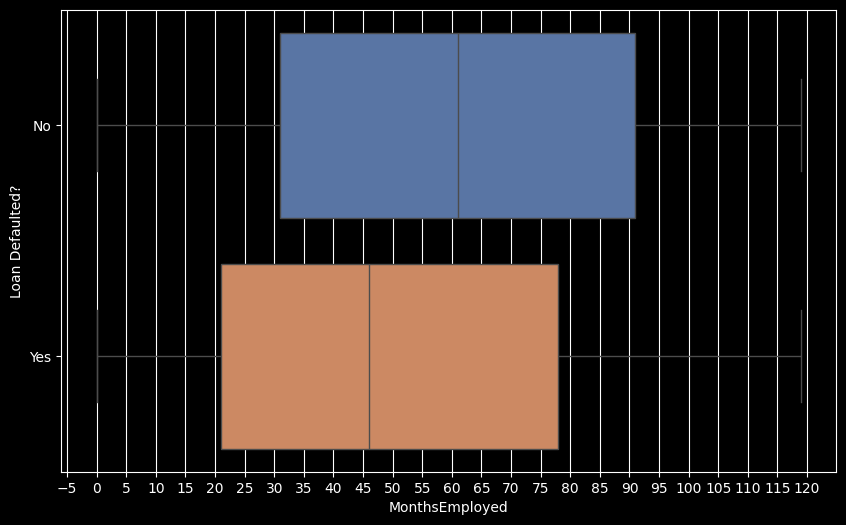

In [62]:
#Lets try to use a ttest to see if employment period have a relationship with the default
a = df[df['Loan Defaulted?']=='Yes'][['MonthsEmployed','LoanID']]
ba = df[df['Loan Defaulted?']=='No'][['MonthsEmployed','LoanID']]
a['MonthsEmployed'] = a['MonthsEmployed'].astype(float)
ba['MonthsEmployed'] = ba['MonthsEmployed'].astype(float)
print(ss.ttest_ind(a['MonthsEmployed'],ba['MonthsEmployed']))

plt.figure(figsize=(10,6))
plt.grid()
sns.boxplot(x='MonthsEmployed',y='Loan Defaulted?',data=df,hue='Loan Defaulted?',palette='deep')
ax= plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.show()

**Conclusion** The months someone has been employed tends to have a slight relationship with the loan amount and defaultment but its relationship with the number of people with defaultment is minimal, therefore I believe that if our objective is to come up with a loan amount limit, the number of months can be used to express that relationship but it doesn't have an effect on the loan defaultment. This can be because someone who has started working can be upto date with their payment than someone who has been employed for some time

**Q5	Does someone’s education level relate to the default status?**

In [63]:
#What are the different education levels?
print(pd.crosstab(df['Education'],df['Loan Defaulted?'],normalize='index',margins=True,margins_name='Probability'))
print("+ + + + + + + + + + +")
print(pd.crosstab(df['Loan Defaulted?'],df['Education'],normalize='index',margins=True,margins_name='Marginal Probability'))

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
#We are going to use ANOVA table to analyze the relationship between Loan Amount and education level for people who have defaulted, people who haven't defaulted and general
print("\n")
a = df[df['Loan Defaulted?']== 'No'][['Education','LoanAmount']]
model = ols('LoanAmount ~ Education',data=a).fit()
print(sm.stats.anova_lm(model, type=2))

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
print("\n")
a = df[df['Loan Defaulted?']== 'Yes'][['Education','LoanAmount']]
model = ols('LoanAmount ~ Education',data=a).fit()
print(sm.stats.anova_lm(model, type=2))

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
print("\n")
model = ols('LoanAmount ~ Education',data=df).fit()
print(sm.stats.anova_lm(model, type=2))

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
print("\n")
df['Default'] = df['Default'].astype(np.int16)
model = ols('Default ~ Education',data=df).fit()
print(sm.stats.anova_lm(model, type=2))

print("+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +")
df['Default'] = df['Default'].astype('category')
print("\n")
model = ols('LoanAmount ~ Default + Education',data=df).fit()
print(sm.stats.anova_lm(model, type=2))


Loan Defaulted?        No       Yes
Education                          
Bachelor's       0.878989  0.121011
High School      0.871211  0.128789
Master's         0.891283  0.108717
PhD              0.894140  0.105860
Probability      0.883872  0.116128
+ + + + + + + + + + +
Education             Bachelor's  High School  Master's       PhD
Loan Defaulted?                                                  
No                      0.250680     0.246675  0.250928  0.251717
Yes                     0.262672     0.277544  0.232961  0.226824
Marginal Probability    0.252073     0.250259  0.248842  0.248826
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +


                 df        sum_sq       mean_sq        F    PR(>F)
Education       3.0  3.377292e+10  1.125764e+10  2.25173  0.080127
Residual   225690.0  1.128349e+15  4.999552e+09      NaN       NaN
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +


                df        sum_sq       mean_sq 

**Conclusion** The education level has a good relationship with the loan default status. This can be due to factors like if someone has a higher education level, they tend to have more financial literacy and a higher chance of having a high-paying job and therefore the ability of paying a loan. Additionally, People who completed their studies with high school diplomas tend to have higher chances of defaulting on their loans as compared to the other groups while people with PHD tend to show a higher probability of repaying their loans

**Q6 Is there a relationship between marital status, dependents, and default status?**

['Divorced' 'Married' 'Single']
                     df        sum_sq    mean_sq          F        PR(>F)
MaritalStatus       2.0     20.565564  10.282782  100.25806  2.989270e-44
Residual       255344.0  26188.883468   0.102563        NaN           NaN


MaritalStatus    Divorced   Married    Single
Loan Defaulted?                              
No               0.329544  0.338658  0.331799
Yes              0.359390  0.299093  0.341517
All              0.333010  0.334063  0.332927


Loan Defaulted?        No       Yes
MaritalStatus                      
Divorced         0.874672  0.125328
Married          0.896028  0.103972
Single           0.880876  0.119124
All              0.883872  0.116128


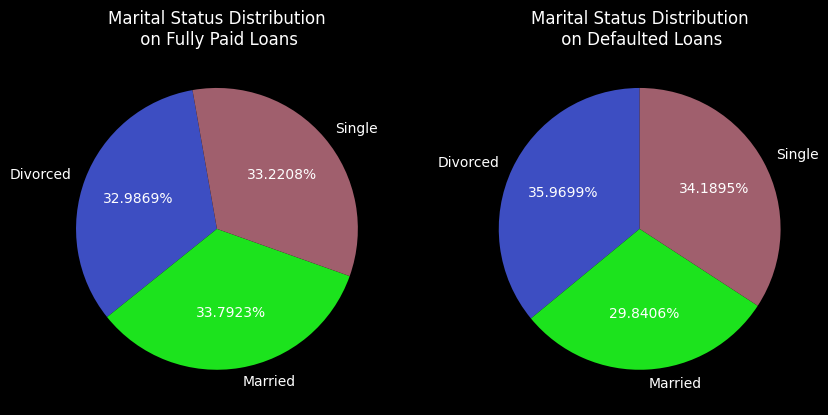

In [64]:
#Lets start by trying to understand what are the different marital status groups we have in our dataset
print(df['MaritalStatus'].unique())
df['Default'] = df['Default'].astype(np.int16)

#Lets try to find out if marital status have a relationship with the defaultment status using ANOVA table because we have more than 2 groups of marital status
print(sm.stats.anova_lm((ols("Default ~ MaritalStatus",data=df).fit()),type=2))
print("\n")

#Lets try to understand their relationships using conditional probabilities
print(pd.crosstab(df['Loan Defaulted?'],df['MaritalStatus'],normalize='index',margins=True))
print("\n")
print(pd.crosstab(df['MaritalStatus'],df['Loan Defaulted?'],normalize='index',margins=True))

#Lets try to visualise our outcmes to have a clear view of their relationships using a piechart, but first we are going to create a dataframe of their probabilities
a = pd.DataFrame(pd.crosstab(df['MaritalStatus'],df['Loan Defaulted?'],normalize='index'))
a.reset_index(inplace=True)

coloring = ["#3D4EC2","#1CE31D","#A05F6D"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.pie(a["No"], labels=a['MaritalStatus'], autopct='%1.4f%%', colors=coloring, startangle=100)
ax1.set_title("Marital Status Distribution\n on Fully Paid Loans")
ax2.pie(a['Yes'], labels=a['MaritalStatus'], autopct='%1.4f%%', colors=coloring, startangle=90)
ax2.set_title("Marital Status Distribution\n on Defaulted Loans")
plt.show()


del a
del fig
del ax1
del ax2

['Yes' 'No']


HasDependents          No       Yes
Loan Defaulted?                    
No               0.493447  0.506553
Yes              0.547567  0.452433
All              0.499732  0.500268


Loan Defaulted?        No       Yes
HasDependents                      
No               0.872756  0.127244
Yes              0.894976  0.105024
All              0.883872  0.116128


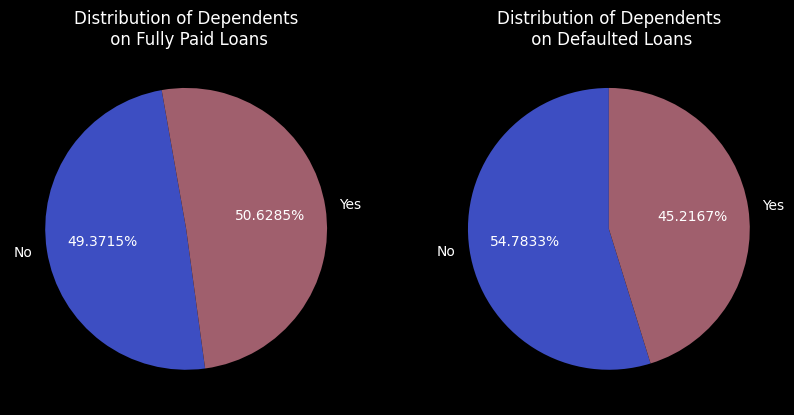

In [65]:
#Lets try to find the relationship behind having dependents
print(df['HasDependents'].unique())
print("\n")

#Lets try to analyze the relationship between Loan Defaultment and Dependents using probabilities
print(pd.crosstab(df['Loan Defaulted?'],df['HasDependents'],normalize='index',margins=True))
print("\n")
print(pd.crosstab(df['HasDependents'],df['Loan Defaulted?'],normalize='index',margins=True))

a = pd.DataFrame(pd.crosstab(df['HasDependents'],df['Loan Defaulted?'],normalize='index'))
a.reset_index(inplace=True)

coloring = ["#3D4EC2","#A05F6D"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.pie(a["No"], labels=a['HasDependents'], autopct='%1.4f%%', colors=coloring, startangle=100)
ax1.set_title("Distribution of Dependents\n on Fully Paid Loans")
ax2.pie(a['Yes'], labels=a['HasDependents'], autopct='%1.4f%%', colors=coloring, startangle=90)
ax2.set_title("Distribution of Dependents\n on Defaulted Loans")

del a
del fig
del ax1
del ax2

**Conclusion** People with dependents and married people tends to show a good sign by most of them paying their loans as compared to the ones who don't have either dependents or are married.

**Q7 Is there a relationship between interest rates, loan terms, and loan amounts?**

2301
                    InterestRate  LoanTerm  Loan Term in Years
InterestRate            1.000000  0.000892            0.000892
LoanTerm                0.000892  1.000000            1.000000
Loan Term in Years      0.000892  1.000000            1.000000
SignificanceResult(statistic=0.0008929411552103686, pvalue=0.6518326143777655)
+ + + + + + + + + + + + + + + + + + + + +

              InterestRate  LoanAmount
InterestRate      1.000000   -0.002291
LoanAmount       -0.002291    1.000000
SignificanceResult(statistic=-0.0022877104086862156, pvalue=0.24767349628145177)
+ + + + + + + + + + + + + + + + + + + + +

                   df        sum_sq    mean_sq         F  PR(>F)
LoanPurpose       4.0  1.341426e+02  33.535651  0.761438  0.5502
Residual     255342.0  1.124591e+07  44.042541       NaN     NaN


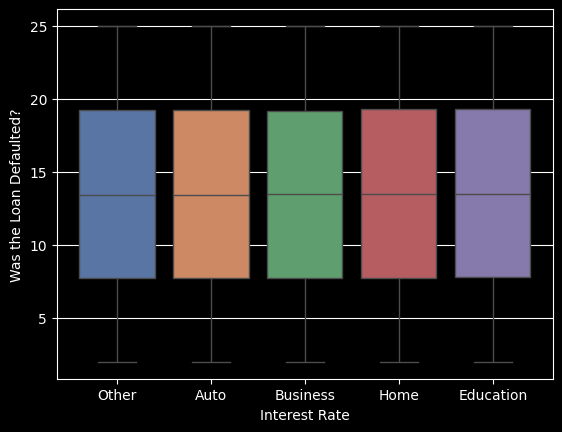

+ + + + + + + + + + + + + + + + + + + + +

                 df        sum_sq    mean_sq         F    PR(>F)
Education       3.0  1.333772e+02  44.459076  1.009461  0.387271
Residual   255343.0  1.124591e+07  44.042372       NaN       NaN


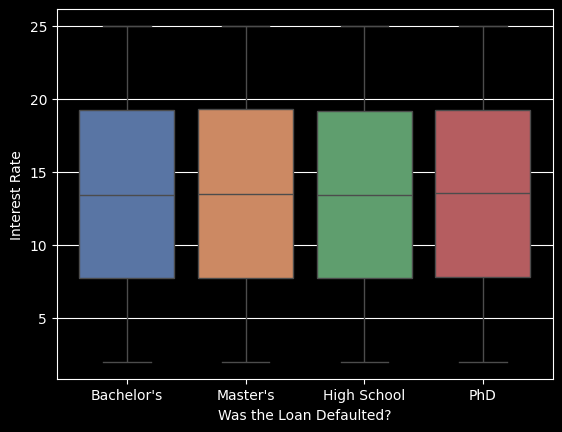

In [66]:
#Lets start by trying to find out how many and what are the interest rates we have in our data
print(len(df['InterestRate'].unique()))
#print(df['InterestRate'].unique())

#Is there a relationship between interest rate and loan term?
print(df[['InterestRate','LoanTerm','Loan Term in Years']].corr())
print(ss.spearmanr(df['InterestRate'], df['LoanTerm']))

print("+ + + + + + + + + + + + + + + + + + + + +\n")
#Is there a relationship between interest rate and loan term?
print(df[['InterestRate','LoanAmount']].corr())
print(ss.spearmanr(df['InterestRate'], df['LoanAmount']))

print("+ + + + + + + + + + + + + + + + + + + + +\n")
#Does loans purpose have a relationship with the interest rates?🤔🤔🤔
model = ols("InterestRate ~ LoanPurpose",data=df).fit()
print(sm.stats.anova_lm(model,type=2))

plt.grid()
sns.boxplot(y='InterestRate', x='LoanPurpose', data=df,hue='LoanPurpose', palette='deep')
plt.xlabel("Interest Rate")
plt.ylabel("Was the Loan Defaulted?")
plt.plot()
plt.show()
print("+ + + + + + + + + + + + + + + + + + + + +\n")
#Does education level have a relationship with the interest rates?🤔🤔🤔
model = ols("InterestRate ~ Education",data=df).fit()
print(sm.stats.anova_lm(model,type=2))

plt.grid()
sns.boxplot(y='InterestRate', x='Education', data=df,hue='Education', palette='deep')
plt.ylabel("Interest Rate")
plt.xlabel("Was the Loan Defaulted?")
plt.plot()
plt.show()

**Conclusion** The Loan Term has no influence over the interest rates<br>
Loan Amount has no relationship with the interest rate<br>
Loan Purpose and education Level has no relationship with the interest rates

**Q8 Is there a relationship between interest rate and default status?**

TtestResult(statistic=66.9135035872001, pvalue=0.0, df=255345.0)


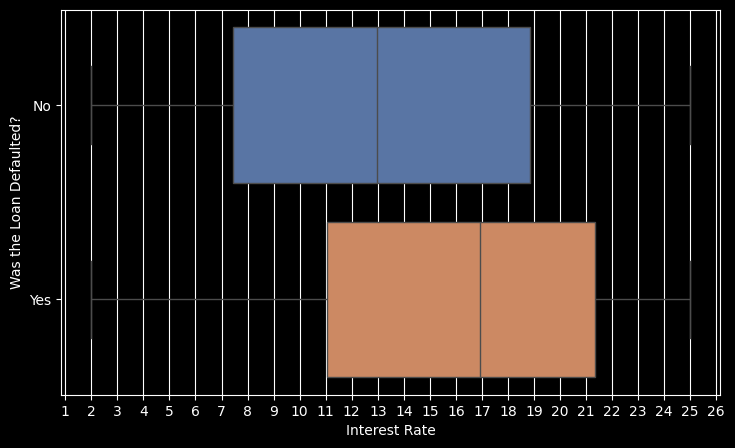

In [67]:
#Lets try to find out if higher interest tends to attract defaultment or in particular if interest rate have a relationship with the defaultment
#In this, we are going to use ttest
a = df[df['Loan Defaulted?'] == 'Yes'][['LoanID','InterestRate']]
b = df[df['Loan Defaulted?'] == 'No'][['LoanID','InterestRate']]

print(ss.ttest_ind(a['InterestRate'],b['InterestRate']))

#Since the PValue is coming to 0, lets try to use boxplot
plt.figure(figsize=(8.5,5))
plt.grid()
sns.boxplot(x='InterestRate', y='Loan Defaulted?', data=df,hue='Loan Defaulted?', palette='deep')
ax= plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.xlabel("Interest Rate")
plt.ylabel("Was the Loan Defaulted?")
plt.plot()

del a
del b

**Conclusion** The boxplot shows that their is a statistically significant relationship between the Interest Rate and Loan Defaultment status, this can be due to various reasons such as the credit institution trying to reduce the risks


**Q9 Is there a relationship between Credit score and interest rate?**

In [68]:
#We are going to use correlation and linegraph to analyze this relationship
print(df[['InterestRate','CreditScore']].corr())

a = df
a['InterestRate'] = round(df['InterestRate'],1)

"""plt.figure(figsize=(14,7))
plt.grid()
sns.lineplot(x='CreditScore',y='InterestRate', palette='deep',hue='Loan Defaulted?',data=a)
ax= plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.xlabel('Credit Score')
plt.ylabel('Interest Rate')
plt.plot()
plt.show()"""

del a

              InterestRate  CreditScore
InterestRate      1.000000     0.000436
CreditScore       0.000436     1.000000


**Conclusion** Interest Rate have no reationship with credit score

**Q10 Is there a relationship between credit score, number of credit cards, and loan status?**

[4 1 3 2]
+ + + + + + + + + + + + + + + + + + + + + + + + + +
                                   df        sum_sq       mean_sq         F  \
Q('Number of Credit Lines')       3.0  3.897939e+04  12993.129082  0.514567   
Residual                     255343.0  6.447560e+09  25250.582829       NaN   

                               PR(>F)  
Q('Number of Credit Lines')  0.672222  
Residual                          NaN  
+ + + + + + + + + + + + + + + + + + + + + + + + + +
Loan Defaulted?               No       Yes
Number of Credit Lines                    
1                       0.894767  0.105233
2                       0.889412  0.110588
3                       0.880753  0.119247
4                       0.870576  0.129424
+ + + + + + + + + + + + + + + + + + + + + + + + + +


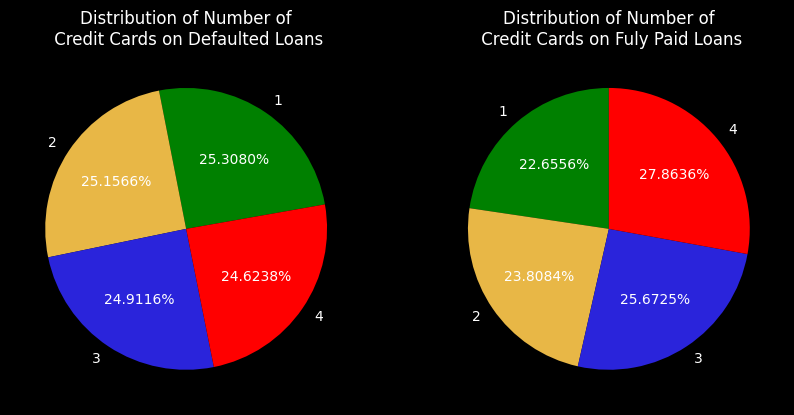

In [69]:
#Lets start by checking the number  of credit lines someone has in the dataset
print(df['Number of Credit Lines'].unique())

#Lets analyze the relationship between Number of credit lines and the credit score and try to figure out if the number of credit lines have a relationship with the credit score
df['Number of Credit Lines'] = df['Number of Credit Lines'].astype("category")
print("+ + + + + + + + + + + + + + + + + + + + + + + + + +")

model = ols("CreditScore ~ Q('Number of Credit Lines')",data=df).fit()
print(sm.stats.anova_lm(model,type=2))

print("+ + + + + + + + + + + + + + + + + + + + + + + + + +")
print(pd.crosstab(df['Number of Credit Lines'],df['Loan Defaulted?'],normalize='index'))

#Lets try to visualize the relationships using piechart. I am going to use subplots
print("+ + + + + + + + + + + + + + + + + + + + + + + + + +")
a = pd.DataFrame(pd.crosstab(df['Number of Credit Lines'],df['Loan Defaulted?'],normalize='index'))
a.reset_index(inplace=True)

coloring = ["#008000","#E8B746","#2A24DB","#FF0000"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.pie(a["No"], labels=a['Number of Credit Lines'], autopct='%1.4f%%', colors=coloring, startangle=10)
ax1.set_title("Distribution of Number of\n Credit Cards on Defaulted Loans")
ax2.pie(a['Yes'], labels=a['Number of Credit Lines'], autopct='%1.4f%%', colors=coloring, startangle=90)
ax2.set_title("Distribution of Number of\n Credit Cards on Fuly Paid Loans")
plt.show()

**Conclusion** Since the P_value is above 0.05, we have enough evidence to reject H<sub>0</sub> and conclude that their is no statistical difference between the mean credit score of different number of credit lines owned<br>
The relationship between the number of credit cards owned and the defaultment status, such that: People with more than 2 credit lines tends to have a higher percentage of not paying their loans as compared to people with one

**Q11 Do people who have mortgages tend to perform better than people who don’t in terms of paying loans?**

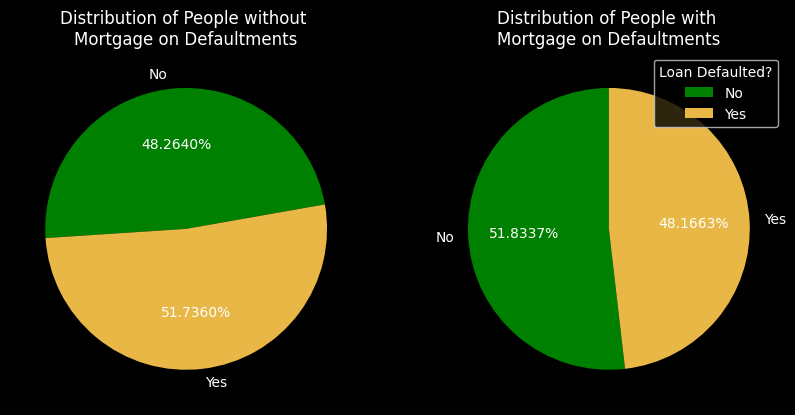

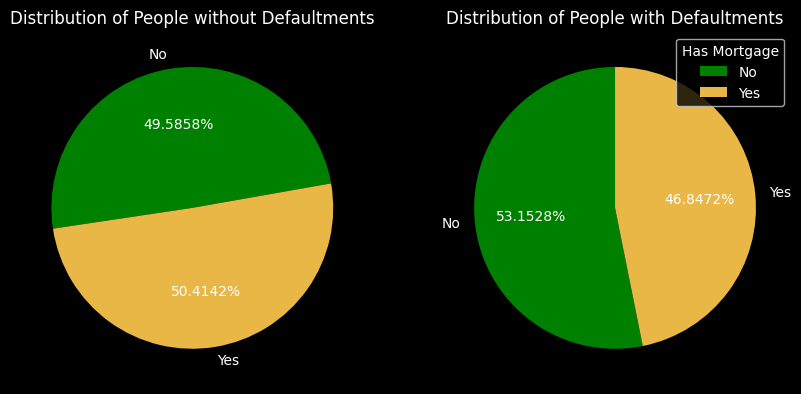

HasMortgage            No       Yes
Loan Defaulted?                    
No               0.495844  0.504156
Yes              0.531515  0.468485
TtestResult(statistic=-11.55263290141999, pvalue=7.287104558818074e-31, df=255345.0)


In [70]:
df['HasMortgage'].unique()

#We are going to use a piechart to analyze this relationship
a = pd.DataFrame(pd.crosstab(df['Loan Defaulted?'],df['HasMortgage'],normalize='index'))
a.reset_index(inplace=True)

coloring = ["#008000","#E8B746"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.pie(a["No"], labels=a['Loan Defaulted?'], autopct='%1.4f%%', colors=coloring, startangle=10)
ax1.set_title("Distribution of People without \nMortgage on Defaultments")
ax2.pie(a['Yes'], labels=a['Loan Defaulted?'], autopct='%1.4f%%', colors=coloring, startangle=90)
ax2.set_title("Distribution of People with \nMortgage on Defaultments")
plt.legend(title="Loan Defaulted?")
plt.show()

#We are going to use a piechart to analyze this relationship
a = pd.DataFrame(pd.crosstab(df['HasMortgage'],df['Loan Defaulted?'],normalize='index'))
a.reset_index(inplace=True)

coloring = ["#008000","#E8B746"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.pie(a["No"], labels=a['HasMortgage'], autopct='%1.4f%%', colors=coloring, startangle=10)
ax1.set_title("Distribution of People without Defaultments")
ax2.pie(a['Yes'], labels=a['HasMortgage'], autopct='%1.4f%%', colors=coloring, startangle=90)
ax2.set_title("Distribution of People with Defaultments")

plt.legend(title="Has Mortgage")
plt.show()
print(pd.crosstab(df['Loan Defaulted?'],df['HasMortgage'],normalize='index'))

a = df[df['HasMortgage'] == 'Yes'][['LoanID','Default']]
b = df[df['HasMortgage'] == 'No'][['LoanID','Default']]

print(ss.ttest_ind(a['Default'],b['Default']))

del a
del b
del fig
del ax1
del ax2

**Conclusion**  Using a ttest, we obtain an extremely small pvalue that is of 7.287104558818074e-31 which indicates thet their is a statistical difference between the mean of people with mortgages and people without thereby leading to the conclusion that mortgage satus have a relationship with the loan defaultment. <br>
Using Pie Chart, we can view their relationship and come up to the conclusion that people with mortgage tends to perform well in paying their loans as compared to people who don't

**Q12 Does Having a cosigner tend to have an effect over someones loan defaultment?**

HasCoSigner            No       Yes
Loan Defaulted?                    
No               0.492804  0.507196
Yes              0.553839  0.446161
All              0.499892  0.500108
TtestResult(statistic=-19.777369345636576, pvalue=5.420926622991166e-87, df=255345.0)


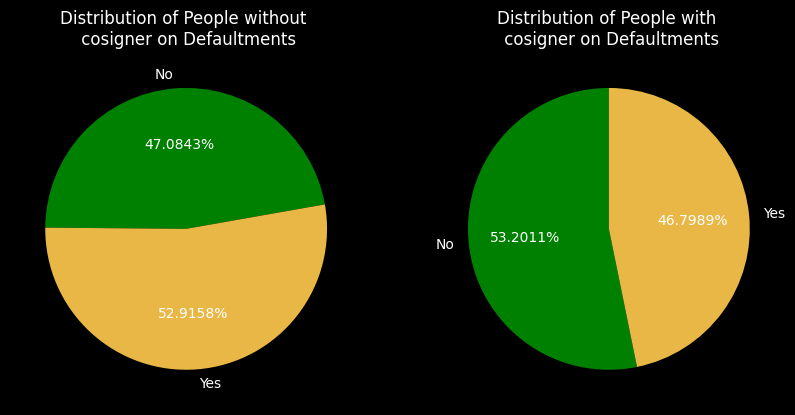

In [71]:
#Lets try to test if having cosigner has a relationship with loan defaultment
#Lets start by using probabilities
print(pd.crosstab(df['Loan Defaulted?'],df['HasCoSigner'],normalize='index',margins=True))

#The prbability matrix doesn't show a clear relationship, lets try using ttest
a = df[df['HasCoSigner'] == 'Yes'][['LoanID','Default']]
b = df[df['HasCoSigner'] == 'No'][['LoanID','Default']]

print(ss.ttest_ind(a['Default'],b['Default']))

c = pd.DataFrame(pd.crosstab(df['Loan Defaulted?'],df['HasCoSigner'],normalize='index'))
c.reset_index(inplace=True)

coloring = ["#008000","#E8B746"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.pie(c["No"], labels=c['Loan Defaulted?'], autopct='%1.4f%%', colors=coloring, startangle=10)
ax1.set_title("Distribution of People without \n cosigner on Defaultments")
ax2.pie(c['Yes'], labels=c['Loan Defaulted?'], autopct='%1.4f%%', colors=coloring, startangle=90)
ax2.set_title("Distribution of People with \n cosigner on Defaultments")
plt.show()

**MACHINE LEARNING MODELS**<br>
Our aim is to build a model that can be used to predict the chances of someone defaulting on a loan they have been issued, we are going to try to use 2 algorithms that is:<ul>
<li>Logistic Regression</li>
<li>XG Boost</li>
</ul>
and then pick the model with the best performance

In [72]:
#Lets start by importing necessary modules that can be used for our model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

#Lets start by droping columns that I came up with for analysis purposes
df1 = df.drop(['Loan Defaulted?','Approximate Annual Income in 500s','Approximate LoanAmount in 500s','Loan Term in Years','Loan to Income Ratio','Number of Credit Lines'],axis=1)
print(df1.info())

#Now lets split the data, that is from the target and the coefficients
#Since we are required to use lots of columns to train our dataset, We are going to just drop the columns not needed and input the new dataframe on the X
x = df1.drop(['LoanID','Default'],axis=1)
df1['Default'] = df1['Default'].astype(np.bool_)

y = df1['Default']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   LoanID                255347 non-null  category
 1   Age                   255347 non-null  int8    
 2   Annual Income         255347 non-null  float64 
 3   LoanAmount            255347 non-null  float64 
 4   CreditScore           255347 non-null  int64   
 5   MonthsEmployed        255347 non-null  int64   
 6   InterestRate          255347 non-null  float64 
 7   LoanTerm              255347 non-null  int64   
 8   Debt to Income Ratio  255347 non-null  float64 
 9   Education             255347 non-null  object  
 10  EmploymentType        255347 non-null  object  
 11  MaritalStatus         255347 non-null  object  
 12  HasMortgage           255347 non-null  object  
 13  HasDependents         255347 non-null  object  
 14  LoanPurpose           255347 non-nul

In [73]:
#Lets convert our data types of dataframe X to numpy dataframe in order to reduce the space and time taken during running our models
x['Age'] = x['Age'].astype(np.uint8)
x['Annual Income'] = x['Annual Income'].astype(np.uint32)
x['LoanAmount'] = x['LoanAmount'].astype(np.uint32)
x['CreditScore'] = x['CreditScore'].astype(np.uint16)
x['InterestRate'] = x['InterestRate'].astype(np.float16)
x['LoanTerm'] = x['LoanTerm'].astype(np.uint16)
x['Debt to Income Ratio'] = x['Debt to Income Ratio'].astype(np.float16)
x['HasMortgage'] = x['HasMortgage'].astype(np.bool_)
x['HasDependents'] = x['HasDependents'].astype(np.bool_)
x['HasCoSigner'] = x['HasCoSigner'].astype(np.bool_)
x['MonthsEmployed'] = x['MonthsEmployed'].astype(np.int8)

print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Age                   255347 non-null  uint8  
 1   Annual Income         255347 non-null  uint32 
 2   LoanAmount            255347 non-null  uint32 
 3   CreditScore           255347 non-null  uint16 
 4   MonthsEmployed        255347 non-null  int8   
 5   InterestRate          255347 non-null  float16
 6   LoanTerm              255347 non-null  uint16 
 7   Debt to Income Ratio  255347 non-null  float16
 8   Education             255347 non-null  object 
 9   EmploymentType        255347 non-null  object 
 10  MaritalStatus         255347 non-null  object 
 11  HasMortgage           255347 non-null  bool   
 12  HasDependents         255347 non-null  bool   
 13  LoanPurpose           255347 non-null  object 
 14  HasCoSigner           255347 non-null  bool   
dtype

After loading and setting up our data, we need to prepare it well<br>
Lets encode our categorical columns


In [74]:
#Lets start by manual encoding of the data, we are going to use a function for this
def change_encode(x):
    if x == 'Yes':
        return '1'
    elif x== 'No':
        return '0'
    else:
        return x

x['HasMortgage'] = x['HasMortgage'].apply(change_encode)
x['HasDependents'] = x['HasDependents'].apply(change_encode)
x['HasCoSigner'] = x['HasCoSigner'].apply(change_encode)

x['HasMortgage'] = x['HasMortgage'].astype(bool)
x['HasDependents'] = x['HasDependents'].astype(bool)
x['HasCoSigner'] = x['HasCoSigner'].astype(bool)


#Lets use pandas library to encode the remaining columns
try:
    x = pd.get_dummies(x,columns=['EmploymentType','Education','MaritalStatus','LoanPurpose'])
except:
    exit
finally:
    X1 = x

**Now that we have already encoded our columns, we can split the dataset into training dataset and testing dataset**

In [75]:
#Lets split our dataset for train test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,y,test_size=0.25, random_state=42)

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(191510, 27)
(63837, 27)
(191510,)
(63837,)


Now that everything is in order, we can start to build our models<br>
Lets start by **Logistic Regression Model**

In [76]:
#Lets start by a simple model before using hyperparameter tuning
classifier1 = LogisticRegression(solver='saga',class_weight='balanced',random_state=42)
classifier1.fit(Xtrain,Ytrain)
Ypredict = classifier1.predict(Xtest)
print("Accuracy Score",accuracy_score(Ypredict,Ytest))

classifier2 = LogisticRegression(solver='sag',class_weight='balanced',random_state=42)
classifier2.fit(Xtrain,Ytrain)
Ypredict = classifier2.predict(Xtest)
print("Accuracy Score",accuracy_score(Ypredict,Ytest))

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy Score 0.6057145542553691
Accuracy Score 0.61248178955778


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Since our accuracy level is small, that is <i>60.57%</i> and <i>61.22%</i>, we need to try to perform hyperparameter tuning on our model. We are going to utilize gridsearch to try and find the best parameters

In [77]:
"""# Adjusted parameter grid
param_grid = {
    'solver': ['saga', 'sag'],
    'penalty': ['l2',None],
    'C': [0.1, 1, 10],
    'tol': [0.01, 0.001],
    'max_iter': [100,200, 500]
}

# Create a logistic regression model
classifier = LogisticRegression(class_weight='balanced', random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=2, scoring='accuracy')

# Use a smaller subset of data
grid_search.fit(Xtest, Ytest)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
"""

'# Adjusted parameter grid\nparam_grid = {\n    \'solver\': [\'saga\', \'sag\'],\n    \'penalty\': [\'l2\',None],\n    \'C\': [0.1, 1, 10],\n    \'tol\': [0.01, 0.001],\n    \'max_iter\': [100,200, 500]\n}\n\n# Create a logistic regression model\nclassifier = LogisticRegression(class_weight=\'balanced\', random_state=42)\n\n# Create a GridSearchCV object\ngrid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=2, scoring=\'accuracy\')\n\n# Use a smaller subset of data\ngrid_search.fit(Xtest, Ytest)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)\n'

We need to conduct Hyperparameter tuning in order to increase the accuracy, but anytime we try to use grid search to obtain the hyperprameter, the kernel dies. Lets try some random tuning

In [78]:
classifier = LogisticRegression(solver='sag',C=0.1,class_weight='balanced',penalty='l2',tol=0.001,n_jobs=-1,max_iter=500,random_state=42)
classifier.fit(Xtrain,Ytrain)
Ypredict = classifier.predict(Xtest)
print("Accuracy Score",accuracy_score(Ypredict,Ytest))

Accuracy Score 0.6373419803562197


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Since our model hasn't performed well, I suggest trying other method that can handle large datasets with ease andcan be used to achieve the objective

In [79]:
#We need to nitializing the model and then fit our data to it
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_classifier.fit(Xtest, Ytest)

#After we have already fit the data, we need to test the dataset using the testing sample then test its accuracy
y_pred_proba = xgb_classifier.predict_proba(Xtest)[:, 1]

#Evaluate the model
y_pred = xgb_classifier.predict(Xtest)
accuracy = accuracy_score(y_pred,Ytest)

print(f"Accuracy: {accuracy}")

Accuracy: 0.908783307486254


In [80]:
"""param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
        }

# Initialize XGBoost classifier but with the parameters we obtained earlier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)"""

'param_grid = {\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'min_child_weight\': [1, 3, 5, 7],\n    \'subsample\': [0.6, 0.8, 1.0],\n        }\n\n# Initialize XGBoost classifier but with the parameters we obtained earlier\nxgb_classifier = xgb.XGBClassifier(objective=\'binary:logistic\', use_label_encoder=False, eval_metric=\'logloss\')\n\n# Create GridSearchCV object\ngrid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\n\n# Fit the model\ngrid_search.fit(Xtrain, Ytrain)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)'

In [81]:
"""param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
        }

# Initialize XGBoost classifier but with the parameters we obtained earlier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)"""

'param_grid = {\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'min_child_weight\': [1, 3, 5, 7],\n    \'subsample\': [0.6, 0.8, 1.0],\n        }\n\n# Initialize XGBoost classifier but with the parameters we obtained earlier\nxgb_classifier = xgb.XGBClassifier(objective=\'binary:logistic\', use_label_encoder=False, eval_metric=\'logloss\')\n\n# Create GridSearchCV object\ngrid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\n\n# Fit the model\ngrid_search.fit(Xtrain, Ytrain)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)'

In [82]:
"""param_grid={
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.05,min_child_weight=7,subsample=0.6, use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)"""

'param_grid={\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'gamma\': [0, 0.1, 0.2, 0.3],\n    \'reg_alpha\': [0, 0.01, 0.1, 1],\n    \'reg_lambda\': [0.1, 1, 10],\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'min_child_weight\': [1, 3, 5, 7],\n    \'subsample\': [0.6, 0.8, 1.0]\n}\n\nxgb_classifier = xgb.XGBClassifier(objective=\'binary:logistic\',learning_rate=0.05,min_child_weight=7,subsample=0.6, use_label_encoder=False, eval_metric=\'logloss\')\n\n# Create GridSearchCV object\ngrid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\n\n# Fit the model\ngrid_search.fit(Xtrain, Ytrain)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)'

In [83]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',colsample_bytree=1.0,gamma=0.2,reg_alpha=1,reg_lambda=1,learning_rate=0.05,min_child_weight=7,subsample=0.6, use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_classifier.fit(Xtrain, Ytrain)
y_pred_proba = xgb_classifier.predict_proba(Xtest)[:, 1]

# Evaluate the model
y_pred = xgb_classifier.predict(Xtest)
accuracy = accuracy_score(y_pred,Ytest)

print(f"Accuracy: {accuracy}")

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8864295001331516


In [84]:
"""param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
        }

# Initialize XGBoost classifier but with the parameters we obtained earlier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain, Ytrain)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)"""

'param_grid = {\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'min_child_weight\': [1, 3, 5, 7],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'gamma\': [0, 0.1, 0.2, 0.3],\n    \'reg_alpha\': [0, 0.01, 0.1, 1],\n    \'reg_lambda\': [0.1, 1, 10],\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'min_child_weight\': [1, 3, 5, 7],\n    \'subsample\': [0.6, 0.8, 1.0]\n        }\n\n# Initialize XGBoost classifier but with the parameters we obtained earlier\nxgb_classifier = xgb.XGBClassifier(objective=\'binary:logistic\', use_label_encoder=False, eval_metric=\'logloss\')\n\n# Create GridSearchCV object\ngrid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\n\n# Fit the model\ngrid_search.fit(Xtrain, Ytrain)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)'

**Model Result**<br>
Since our models have poor perfomance both logistic regression and XGBoost, I suggest the use of Reccursive Feature Elimination with cross validation to recheck the columns that we have:

In [85]:
#Lets start by first importing the necessary libraries
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

#Lets start by creating the models both for XGBoosta and RFECV
model =xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.05,min_child_weight=7,subsample=0.6,  eval_metric='logloss')
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

rfecv.fit(Xtrain, Ytrain)

# Get the selected features
selected_features = rfecv.support_
ranking = rfecv.ranking_
optimal_num_features = rfecv.n_features_

print("Selected Features:", selected_features)
print("Feature Ranking:", ranking)
print("Optimal Number of Features:", optimal_num_features)
print(Xtrain.columns)

Selected Features: [ True  True  True  True  True  True  True  True False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 2 3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal Number of Features: 24
Index(['Age', 'Annual Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'InterestRate', 'LoanTerm', 'Debt to Income Ratio', 'HasMortgage',
       'HasDependents', 'HasCoSigner', 'EmploymentType_Full-time',
       'EmploymentType_Part-time', 'EmploymentType_Self-employed',
       'EmploymentType_Unemployed', 'Education_Bachelor's',
       'Education_High School', 'Education_Master's', 'Education_PhD',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'LoanPurpose_Auto', 'LoanPurpose_Business',
       'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other'],
      dtype='object')


In [86]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',colsample_bytree=1,gamma=0.2,reg_alpha=1,reg_lambda=1,learning_rate=0.05,min_child_weight=7,subsample=0.6, use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_classifier.fit(Xtrain, Ytrain)
y_pred_proba = xgb_classifier.predict_proba(Xtest)[:, 1]

# Evaluate the model
y_pred = xgb_classifier.predict(Xtest)
accuracy = accuracy_score(y_pred,Ytest)

print(f"Accuracy: {accuracy}")

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8864295001331516


**Results testing**<BR>
Above, we used the general dataset. Now lets use the columns we find intresting

In [87]:
# Feature selection
X2 = x[['Age', 'Annual Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'InterestRate', 'LoanTerm', 
        'Debt to Income Ratio', 'HasMortgage', 'HasDependents', 'HasCoSigner', 'EmploymentType_Full-time', 
        'EmploymentType_Part-time', 'EmploymentType_Self-employed', 'EmploymentType_Unemployed', 
        "Education_Bachelor's", 'Education_High School', "Education_Master's", 'Education_PhD', 
        'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single']]

# Train-test split
X2Train, X2Test, Y2Train, Y2Test = train_test_split(X2, y, test_size=0.25, random_state=42)

# Model training
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=1, gamma=0.2, reg_alpha=1, reg_lambda=1, 
learning_rate=0.05, min_child_weight=7, subsample=0.6, use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X2Train, Y2Train)

# Predictions
y_pred_proba = xgb_classifier.predict_proba(X2Test)[:, 1]
y_pred = xgb_classifier.predict(X2Test)

# Evaluation
accuracy = accuracy_score(y_pred, Y2Test)
print(f"Accuracy: {accuracy}")


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8863355107539514


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# ... preprocess data as described ...

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions   
 on new data
new_data = ...  # Prepare new data with the same features as X_train
predicted_interest_rate = model.predict(new_data)

**Interest Rate model**<br>
Lets try to come up with a model that can be used to predict the interest rate someone is going to be charged

In [88]:
target = X2[['InterestRate']]
predictors =X2.drop(['InterestRate'],axis=1)

targetTrain, targetTest, predictorsTrain, predictorsTest = train_test_split(target,predictors,test_size=0.25,random_state=2)
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=1, gamma=0.2, reg_alpha=1, reg_lambda=1, 
                                 learning_rate=0.05, min_child_weight=7, subsample=0.6, n_estimators=100)
xgb_regressor.fit(predictorsTrain,targetTrain)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = xgb_regressor.predict(predictorsTest)
mse = mean_squared_error(targetTest, y_pred)
r2 = r2_score(targetTest, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 44.18924331665039
R^2 Score: -0.001590728759765625


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   LoanID                             255347 non-null  category
 1   Age                                255347 non-null  int8    
 2   Annual Income                      255347 non-null  float64 
 3   LoanAmount                         255347 non-null  float64 
 4   CreditScore                        255347 non-null  int64   
 5   MonthsEmployed                     255347 non-null  int64   
 6   Number of Credit Lines             255347 non-null  category
 7   InterestRate                       255347 non-null  float64 
 8   LoanTerm                           255347 non-null  int64   
 9   Debt to Income Ratio               255347 non-null  float64 
 10  Education                          255347 non-null  object  
 11  EmploymentType            